## Titanic with Pipeline

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/pillar.jpg' width=600>

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer,OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [79]:
path ='https://frenzy86.s3.eu-west-2.amazonaws.com/fav/tecno/titanic.csv'
df = pd.read_csv(path, sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [80]:
#remove features not useful
features_to_remove = ['Name', 'PassengerId', 'Ticket', 'Cabin']
df_clean = df.drop(features_to_remove, axis=1)

#Feature matrix and target vector
X = df_clean.drop(['Survived'], axis=1)
y = df_clean['Survived']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=667,
                                                    )

In [82]:
y

0      0
1      1
2      1
3      1
4      0
      ..
151    1
152    0
153    0
154    0
155    0
Name: Survived, Length: 156, dtype: int64

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/pipes.png' width=700>

## Simple Imputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

The imputation strategy:

- If “mean”, then replace missing values using the mean along each column. Can only be used with numeric data.

- If “median”, then replace missing values using the median along each column. Can only be used with numeric data.

- If “most_frequent”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.

- If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.



In [83]:
## dividiamo automaticamente le features numeriche da quelle categoriche

numerical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind in ['i','f'] ]
categorical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind not in ['i','f']]

print('Numerical : ' + str(numerical_features))
print('Categorical : ' + str(categorical_features))

Numerical : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical : ['Sex', 'Embarked']


In [84]:
## Parte di processingdata: Cleaning, fill Nan + OHE
Preprocessor = make_column_transformer(
                                        (make_pipeline(
                                        SimpleImputer(strategy = 'median'),
                                        KBinsDiscretizer(n_bins=3)), numerical_features),

                                        (make_pipeline(
                                        #FunctionTransformer(lambda x: np.where(x == 'n.d.', np.nan, x)),
                                        SimpleImputer(strategy = 'constant', fill_value = 'missing'),
                                        OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features)
                                        )

In [85]:
scaler = StandardScaler()

classifier = RandomForestClassifier(bootstrap=True,
                                    max_depth=80,
                                    max_features=2,
                                    min_samples_leaf=3,
                                    min_samples_split=8,
                                    n_estimators=100
                                    )
#classifier = LogistiRegression()

In [86]:
model_pipe = Pipeline([
                       ('Preprocessing features', Preprocessor),
                       ('Scaling and standadize data', scaler),
                       ('Classifier', classifier)
                      ])
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [87]:
print(f'Train Accuracy: {model_pipe.score(X_train, y_train):.3f}')
print(f'Test Accuracy : {model_pipe.score(X_test, y_test):.3f}')

Train Accuracy: 0.821
Test Accuracy : 0.769


In [88]:
from sklearn.model_selection import cross_val_score

cross = cross_val_score(model_pipe,X,y,cv=5)
round(np.mean(cross),3)

0.807

### Prediction of Test

In [89]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/titanic-test.csv

Pclass	Sex	Age	SibSp	Parch	Fare	Embarked
(1,male,35,1,0,53.1,S)

In [90]:
test = pd.read_csv('https://frenzy86.s3.eu-west-2.amazonaws.com/python/titanic-test.csv')
test_clean = test.drop(features_to_remove, axis = 1)
test_clean

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [91]:
test_pred = model_pipe.predict(test_clean).astype(int)
test_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [92]:
#kaggle export
sub = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                        'Survived' : test_pred})

sub.to_csv("solu_RF_pipe.csv", index = False)

## Prediction of single observation

In [93]:
Age= 34
Embarked = 'Q'
Fare =7.8
Parch = 0
Pclass = 3
Sex = 'female'
SibSp = 0

#tupla = (Age,Embarked,Fare,Parch,Pclass,Sex,SibSp)
#x = [name for name, value in locals().items() if value in tupla]
x = ['Age','Embarked','Fare','Parch','Pclass','Sex','SibSp']
data = {}
for variable in x:
    value = eval(variable)
    data[variable] = [value]
input_df = pd.DataFrame(data)
res = model_pipe.predict(input_df).astype(int)[0]
print(res)

classes = {0:'died',
           1:'survived'
           }

y_pred = classes[res]
y_pred

1


'survived'

In [94]:
import joblib

joblib.dump(model_pipe,'titanic.pkl')

['titanic.pkl']

## Load model .pkl

In [95]:
import joblib

model_pipe = joblib.load('titanic.pkl')
print('Model loaded successfully')

Model loaded successfully


In [96]:
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [97]:
import pandas as pd

Age= None
Embarked = 'Q'
Fare =7.8
Parch = 0
Pclass = 3
Sex = 'female'
SibSp = 0

# tupla = (Age,Embarked,Fare,Parch,Pclass,Sex,SibSp)
# x = [name for name, value in locals().items() if value in tupla]
x = ['Age','Embarked','Fare','Parch','Pclass','Sex','SibSp']

data = {}
for variable in x:
    value = eval(variable)
    data[variable] = [value]
input_df = pd.DataFrame(data)
res = model_pipe.predict(input_df).astype(int)[0]
print(res)

classes = {0:'died',
           1:'survived'
           }

y_pred = classes[res]
y_pred

1


'survived'

## Test Pipeline con PCA prima del Classifier

In [98]:
from sklearn.decomposition import PCA

model_pipe_pca = Pipeline([
                        ('Preprocessing features', Preprocessor),
                        ('Scaling and standadize data', scaler),
                        ('Dim. Reduction', PCA()), # sempre prima del classifier e dopo lo scaling
                        ('Classifier', classifier)
                        ])

model_pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Dim. Reduction', PCA()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [99]:
print(f'Train Accuracy: {model_pipe_pca.score(X_train, y_train):.3f}')
print(f'Test Accuracy : {model_pipe_pca.score(X_test, y_test):.3f}')

Train Accuracy: 0.872
Test Accuracy : 0.872


## La PCA ha cambiato di moltissimo sul test set, meno overfitting

In [100]:
from sklearn.model_selection import cross_val_score

cross = cross_val_score(model_pipe_pca,X,y,cv=5)
print(cross)
print(round(np.mean(cross),3))


[0.875      0.77419355 0.80645161 0.77419355 0.74193548]
0.794


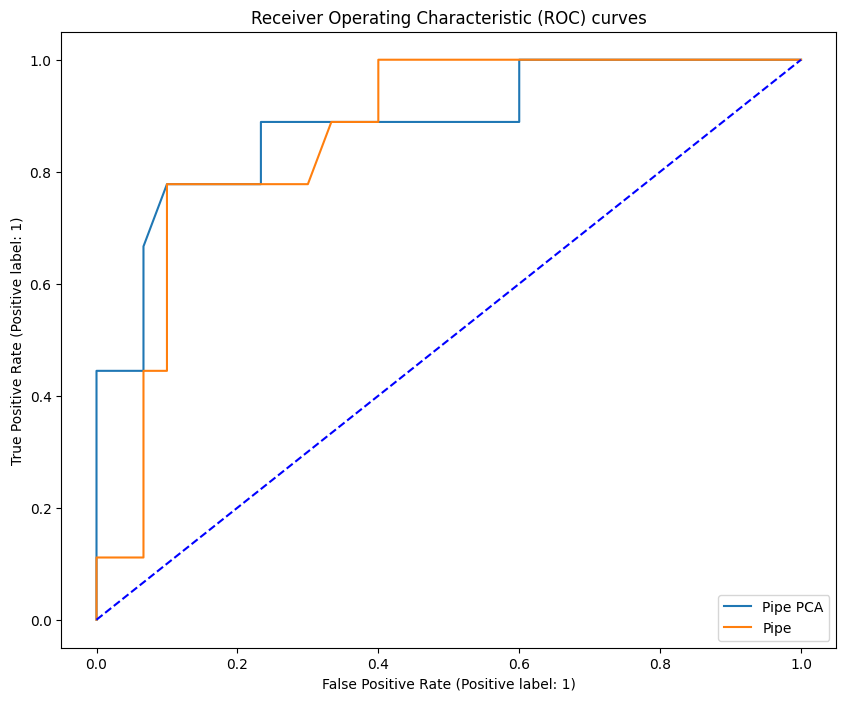

In [101]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10,8))
ax = plt.gca()

RocCurveDisplay.from_estimator(model_pipe_pca, X_test, y_test,label='Pipe PCA',ax=ax)
RocCurveDisplay.from_estimator(model_pipe, X_test, y_test,label='Pipe',ax=ax)
plt.plot([0,1],[0,1],'--b')

plt.title("Receiver Operating Characteristic (ROC) curves")
plt.legend(loc=4);

##Fit the model with entire dataset

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/cross.png' width=600>



In [102]:
model_pipe_pca.fit(X,y)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Dim. Reduction', PCA()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [103]:
import joblib

joblib.dump(model_pipe_pca,'PipePCA_titanic.pkl')

['PipePCA_titanic.pkl']